In [256]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [257]:
import numpy as np
import pandas as pd

In [258]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [259]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [260]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [261]:
# Declare Base
Base = automap_base()

In [262]:
# Use the base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [263]:
# View all of the classes mapped to the base
Base.classes.keys()

['measurement', 'station']

In [264]:
# Assign the classes to variables

In [265]:
measurement = Base.classes.measurement
station = Base.classes.station

In [266]:
# View columns in depth view
measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [267]:
# View columns
measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [268]:
# View columns in depth view
station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [269]:
# View columns
station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [270]:
# Create Session
session = Session(engine)

# Exploratory Climate Analysis

In [271]:
session.query(measurement.date, measurement.prcp).order_by(measurement.date.desc()).limit(1).all()

[('2017-08-23', 0.0)]

In [272]:
# Define date for 12 months prior to last date from dataset
from dateutil.relativedelta import relativedelta
query_date = dt.date(2017, 8, 23) - relativedelta(months = 12)

# Execute Query
query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= query_date).all()
df = pd.DataFrame(query)
df = df.set_index('date')
df = df.sort_index()
df.isnull().sum()

prcp    209
dtype: int64

In [273]:
df.head(15)

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


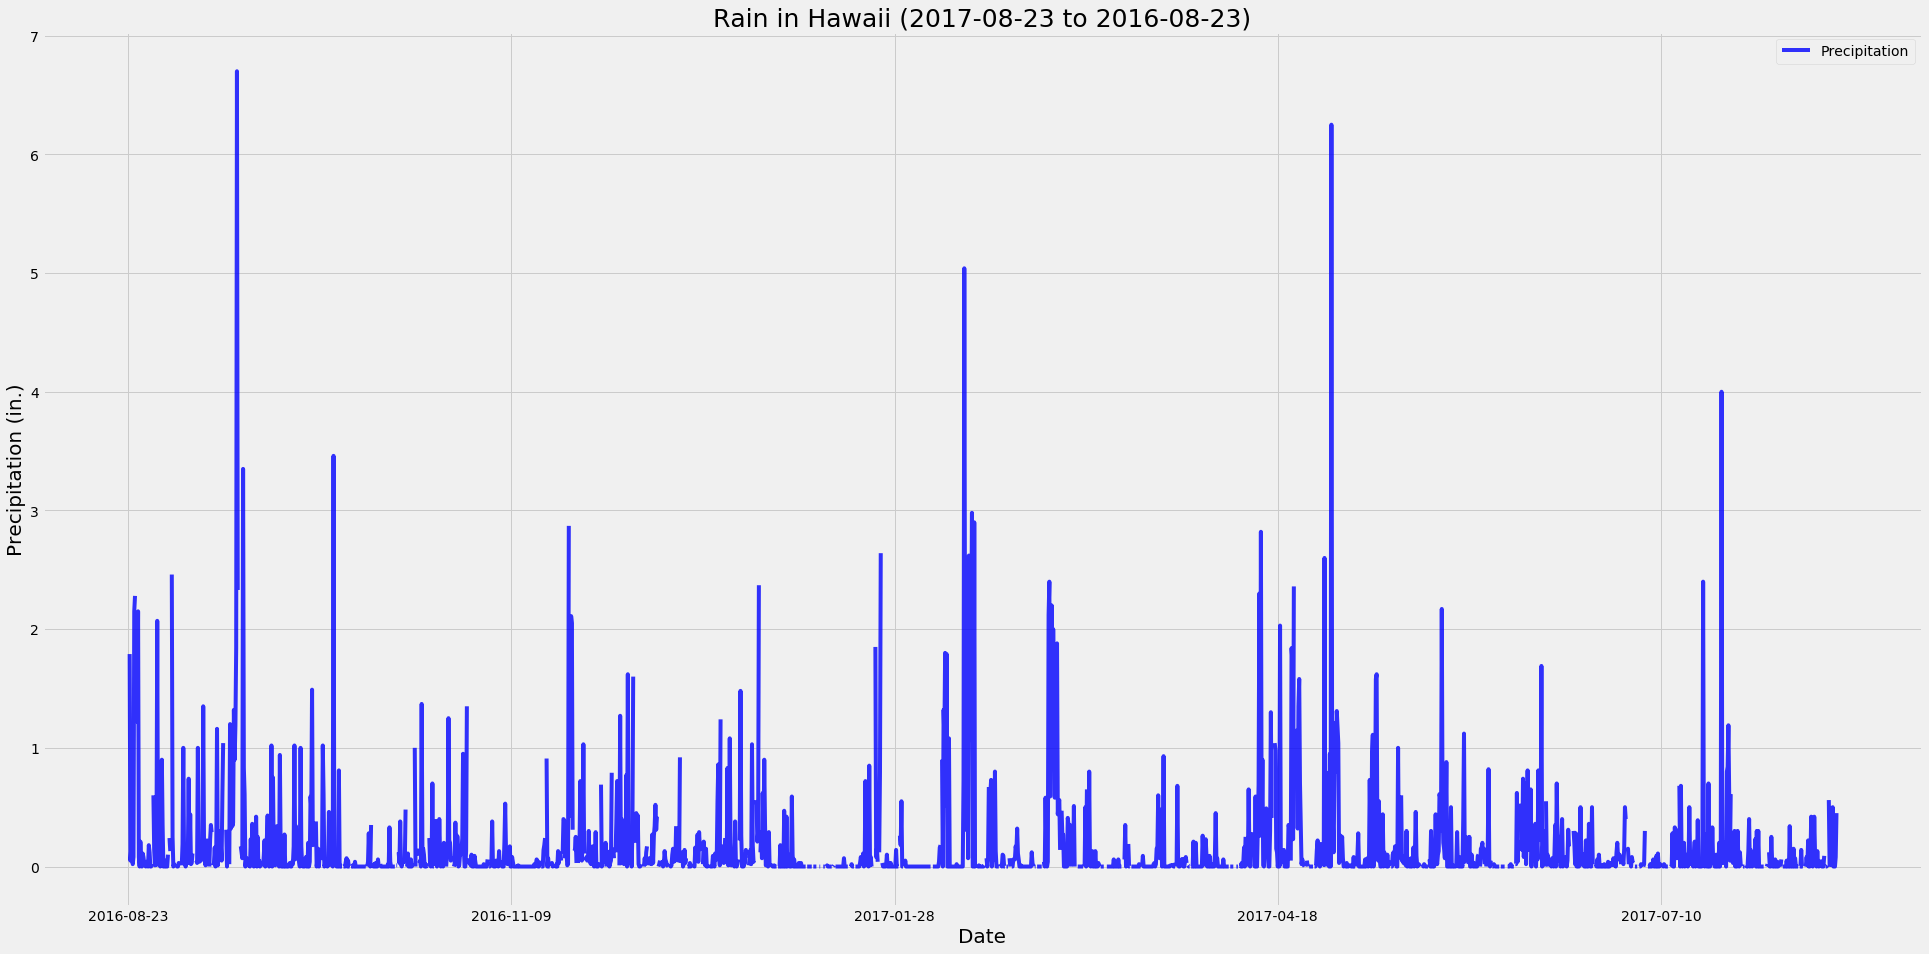

In [274]:
df.plot(figsize=(30,15), color='blue', alpha=0.8, rot=0)
plt.title('Rain in Hawaii (2017-08-23 to 2016-08-23)', fontsize=25)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Precipitation (in.)', fontsize=20)
plt.legend(['Precipitation'])

In [275]:
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [276]:
# Number of stations in data set
stations = session.query(measurement.station).group_by(measurement.station).count()
print(f'Total Stations: {stations}.')

Total Stations: 9.


In [277]:
# What are the most active stations?
stations_act = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc())
for row in stations_act:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [278]:
# Low temp, High Temp, and Average Temp for USC00519281
low_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
high_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
print(f'Station: USC00519281\nLow Temp. = {low_temp[0]}\nHigh Temp. = {high_temp[0]}\nAvg. Temp. = {round(avg_temp[0],1)}')

Station: USC00519281
Low Temp. = 54.0
High Temp. = 85.0
Avg. Temp. = 71.7


In [279]:
# Choose the station with the highest number of temperature observations.
stations_act = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc())
for row in stations_act:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


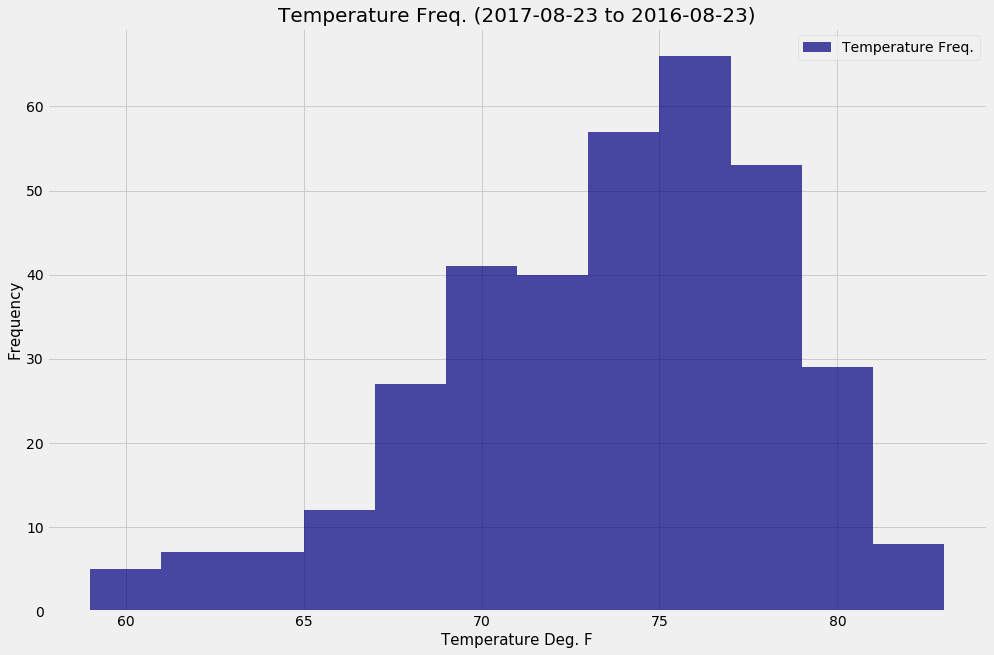

In [280]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(measurement.tobs).filter(measurement.station == 'USC00519281').filter(measurement.date >= query_date).all()
df = pd.DataFrame(query)
df.plot.hist(bins=12, color='navy', alpha=0.7, grid=True, figsize=(15,10))
plt.title('Temperature Freq. (2017-08-23 to 2016-08-23)', fontsize=20)
plt.xlabel('Temperature Deg. F', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.legend(['Temperature Freq.'])

## Bonus Challenge Assignment

In [281]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [251]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [175]:
# session.close()

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

[{'USC00519397': 'WAIKIKI 717.2, HI US'},
 {'USC00513117': 'KANEOHE 838.1, HI US'},
 {'USC00514830': 'KUALOA RANCH HEADQUARTERS 886.9, HI US'},
 {'USC00517948': 'PEARL CITY, HI US'},
 {'USC00518838': 'UPPER WAHIAWA 874.3, HI US'},
 {'USC00519523': 'WAIMANALO EXPERIMENTAL FARM, HI US'},
 {'USC00519281': 'WAIHEE 837.5, HI US'},
 {'USC00511918': 'HONOLULU OBSERVATORY 702.2, HI US'},
 {'USC00516128': 'MANOA LYON ARBO 785.2, HI US'}]

In [283]:
def start(date):
    results = session.query(measurement.date, func.avg(measurement.tobs), func.max(measurement.tobs), func.min(measurement.tobs)).filter(measurement.date >= date).all()
    print(results)

    

In [284]:
start('2017-01-01')

[('2017-04-30', 74.14387974230493, 87.0, 58.0)]
